In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [17]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, TensorDataset  # For data handling
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For data preprocessing

In [18]:
# Step 1: Load and Prepare Data
# ------------------------------
# Load the dataset from CSV file
data = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')

In [19]:
# Remove columns that don't contribute to prediction
# - RowNumber, CustomerId, and Surname are identifiers
# - Exited is our target variable (what we want to predict)
X = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = data['Exited']  # Target variable (1 if customer exited, 0 otherwise)

In [20]:
# Step 2: Split Data into Training and Test Sets
# ----------------------------------------------
# Split data into 80% training and 20% testing
# stratify=y ensures same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Important for imbalanced datasets
    random_state=42  # For reproducibility
)

In [21]:
# Step 3: Preprocess Data
# -----------------------
# Identify different types of features
categorical_cols = ['Geography', 'Gender']  # Text-based categories
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']  # Numerical values

In [23]:
# Process categorical features using one-hot encoding
# drop='first' removes redundant columns to prevent multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])  # Fit and transform training data
X_test_cat = encoder.transform(X_test[categorical_cols])  # Transform test data (no fitting!)


## what does scaled features means ?
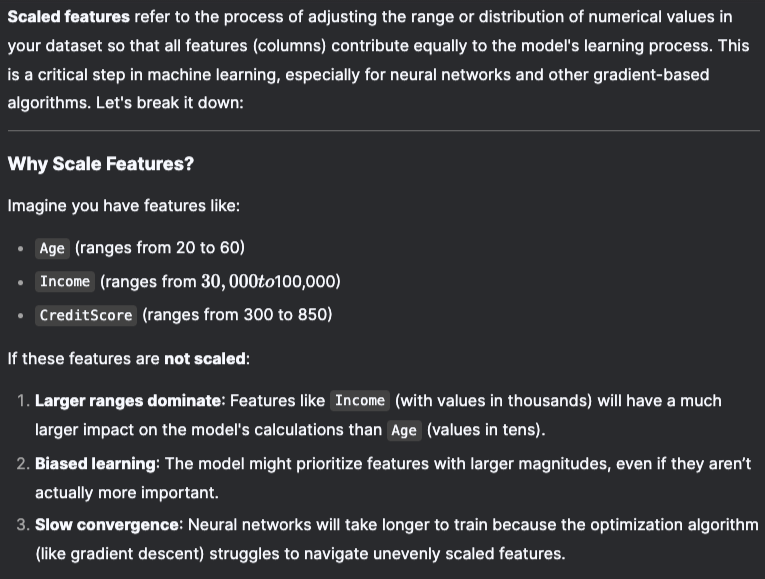

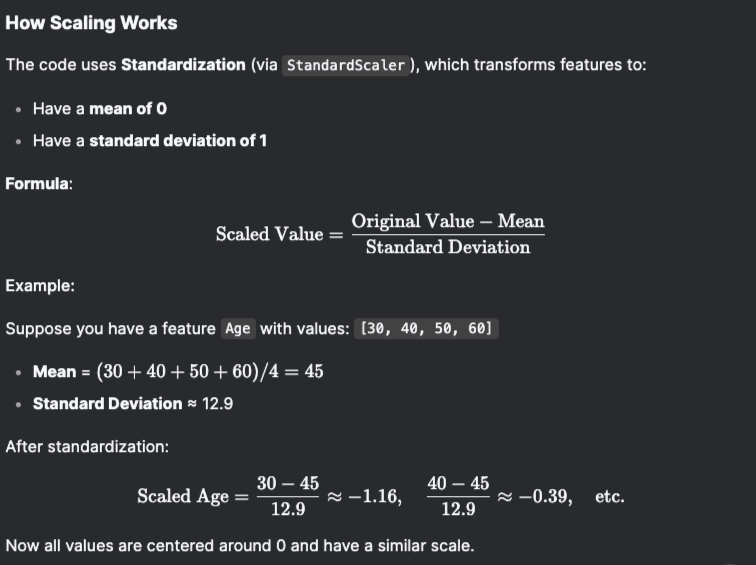

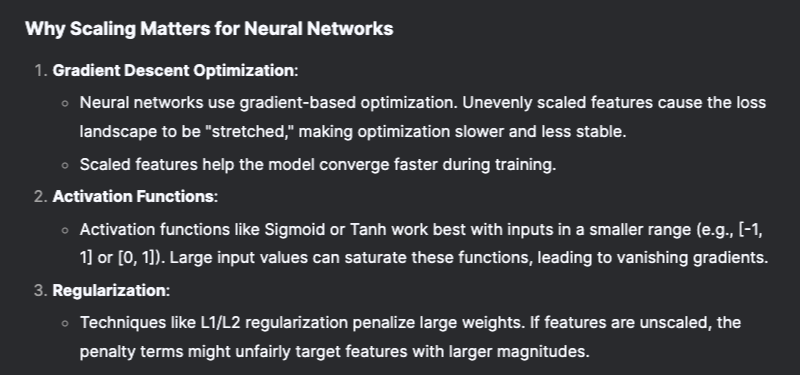

In [24]:
# Process numerical features using standardization
# Neural networks work better with scaled features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])  # Fit and scale training data
X_test_num = scaler.transform(X_test[numerical_cols])  # Scale test data using same parameters

In [25]:
# Combine processed features back together
X_train_processed = np.hstack((X_train_num, X_train_cat))
X_test_processed = np.hstack((X_test_num, X_test_cat))

In [26]:
# Step 4: Convert Data to PyTorch Tensors
# ---------------------------------------
# Convert numpy arrays to PyTorch tensors
# float32 is standard dtype for neural networks
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [27]:
# Step 5: Create Data Loader
# --------------------------
# Create dataset and loader for batch training
batch_size = 64  # Number of samples per training batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True  # Important to shuffle for better learning
)

Let me explain the choice of **batch_size = 64** in simple terms:

---

### **What is Batch Size?**
Batch size determines **how many training samples** are used in one iteration to update the neural network's weights. Instead of processing the entire dataset at once (computationally expensive) or one sample at a time (very noisy), we use **batches**.

---

### **Why 64?**
1. **Computational Efficiency**:
   - GPUs (graphics cards used for deep learning) process data most efficiently when batch sizes are **powers of 2** (32, 64, 128, 256). This is because:
     - Memory allocation on GPUs works better with powers of 2.
     - Parallel processing units (CUDA cores) are optimized for these sizes.
   - 64 is a **common default** that balances speed and memory usage.

2. **Generalization**:
   - Smaller batches (e.g., 32) introduce more randomness/noise, which can help avoid overfitting.
   - Larger batches (e.g., 128) give smoother gradients but may generalize poorly.
   - 64 strikes a **balance** between these extremes.

3. **Memory Constraints**:
   - Larger batches require more GPU memory. For most consumer-grade GPUs (e.g., NVIDIA RTX 3060 with 12GB RAM), 64 is a safe choice that won’t cause "out of memory" errors.

4. **Empirical Success**:
   - 64 is widely used in practice and works well for many datasets. Researchers often start with this value and tune it later if needed.

---

### **Example Analogy**
Imagine you’re learning to cook:
- **Batch size = 1**: Taste-test after every single bite (slow, erratic learning).
- **Batch size = 64**: Taste-test after every 64 bites (balanced feedback).
- **Batch size = entire dataset**: Taste-test only at the end (slow, misses nuances).

---

### **What If We Changed It?**
- **Smaller (e.g., 32)**:
  - More frequent updates (faster convergence).
  - More noisy gradients (may escape local minima).
  - Slower due to more iterations.

- **Larger (e.g., 128)**:
  - Smoother gradients (stable training).
  - Faster processing (better GPU utilization).
  - Risk of overfitting to patterns in large batches.

---

### **Key Takeaway**
64 is a **safe starting point** for most problems. In your code:
```python
batch_size = 64  # Balances speed, memory, and learning stability
```
You can experiment with other values (32, 128) later, but 64 works well for this customer churn prediction task. 🚀

---

### **Bonus Tip**
If you’re curious, try:
```python
batch_size = 32  # See if accuracy improves
batch_size = 128  # Check if training becomes faster
```
Compare results to see how batch size affects your model!

In [29]:
# Step 6: Define Neural Network Architecture
# ------------------------------------------
class ANN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Layer 1: Input layer to first hidden layer
        self.layer1 = nn.Linear(input_size, 128)
        # Layer 2: Hidden layer to second hidden layer
        self.layer2 = nn.Linear(128, 64)
        # Layer 3: Final hidden layer to output layer
        self.layer3 = nn.Linear(64, 1)
        
        # Activation function
        self.relu = nn.ReLU()  # Introduces non-linearity
        
        # Regularization
        self.dropout = nn.Dropout(0.2)  # Helps prevent overfitting
        
    def forward(self, x):
        # Forward pass through network
        x = self.dropout(self.relu(self.layer1(x)))  # Layer1 + activation + dropout
        x = self.dropout(self.relu(self.layer2(x)))  # Layer2 + activation + dropout
        x = self.layer3(x)  # Final layer (no activation here)
        return x

Let's break down the code and concepts step by step:

---

### **1. `input_size` Explanation**
```python
def __init__(self, input_size):
    self.layer1 = nn.Linear(input_size, 128)
```
- **What it is**: `input_size` = Number of features in your processed dataset (after one-hot encoding and scaling).
- **Why needed**: The first layer needs to know how many input neurons to expect (one per feature).
- **Calculation**: If your dataset has 10 processed features, `input_size=10`.

---

### **2. Hardcoded Numbers (128, 64)**
```python
self.layer1 = nn.Linear(input_size, 128)  # 128 neurons
self.layer2 = nn.Linear(128, 64)          # 64 neurons
```
- **Why these numbers**:
  1. **Common Practice**: Powers of 2 (64, 128, 256) work well with GPU memory alignment.
  2. **Progressive Compression**: Reduces dimensions gradually (128 → 64 → 1) to learn hierarchical patterns.
  3. **Balanced Capacity**: Enough neurons to learn complex patterns without overfitting.
- **Note**: These are hyperparameters - you can experiment with other values (e.g., 256, 32).

---

### **3. Activation Function (ReLU)**
```python
self.relu = nn.ReLU()
```
- **What it does**: 
  - ReLU (Rectified Linear Unit) = `max(0, x)`
  - Introduces **non-linearity** (crucial for learning complex patterns).
- **Why ReLU**:
  - Computationally efficient
  - Mitigates vanishing gradient problem
  - Works better than sigmoid/tanh in deep networks

---

### **4. Dropout (0.2)**
```python
self.dropout = nn.Dropout(0.2)
```
- **What it does**: Randomly deactivates 20% of neurons during training.
- **Why used**:
  - Prevents overfitting by reducing co-dependency between neurons
  - Acts as regularization
- **Why 0.2**: A common starting value for hidden layers (balances regularization strength).

---

### **5. No Activation in Last Layer**
```python
self.layer3 = nn.Linear(64, 1)  # No activation
```
- **Why**:
  1. **Loss Function Compatibility**: `BCEWithLogitsLoss` (used in training) already includes a sigmoid activation.
  2. **Numerical Stability**: Combining sigmoid + cross-entropy in one function is more stable.
  3. **Interpretation**: Raw outputs ("logits") can be interpreted as confidence scores.

---

### **6. `forward()` Method Overriding**
```python
def forward(self, x):
    x = self.dropout(self.relu(self.layer1(x)))
    ...
    return x
```
- **Why Override**:
  - PyTorch requires defining how data flows through the network.
  - Specifies the exact order of operations (layers → activation → dropout).
- **How It Works**:
  - PyTorch automatically calls `forward()` during training/prediction.
  - Overriding defines the custom computation graph.

---

### **Full Architecture Flow**
1. **Input** → `input_size` features  
2. **Layer 1** → 128 neurons  
   - ReLU activation → Non-linearity  
   - Dropout → Regularization  
3. **Layer 2** → 64 neurons  
   - ReLU activation → Non-linearity  
   - Dropout → Regularization  
4. **Layer 3** → 1 neuron (output)  
   - No activation → Raw logits for loss calculation  

---

### **Key Design Choices**
1. **Progressive Sizing** (128 → 64 → 1):  
   - Gradually reduces dimensions to extract meaningful patterns.  
2. **ReLU + Dropout Combo**:  
   - Enables learning complex relationships while preventing overfitting.  
3. **Output Layer Simplicity**:  
   - Avoids squashing outputs prematurely for better loss calculation.  

---

### **Visual Representation**
```
Input (Features)  
    │  
    ▼  
[128 Neurons] → ReLU → Dropout  
    │  
    ▼  
[64 Neurons] → ReLU → Dropout  
    │  
    ▼  
[1 Neuron] (Raw Output)  
```

This architecture balances learning capacity and computational efficiency for the customer churn prediction task.

## Let's break down the parameters in `nn.Linear(128, 64)` and explain their role in the neural network:

---

### **`nn.Linear(in_features, out_features)`**
In PyTorch, `nn.Linear` defines a **fully connected (dense) layer** in a neural network. The two parameters are:

1. **`in_features`**: Number of input neurons/features  
   - What the layer **receives** from the previous layer or input data  
   - Example: `128` means this layer takes 128 values as input  

2. **`out_features`**: Number of output neurons/features  
   - What the layer **produces** for the next layer  
   - Example: `64` means this layer outputs 64 values  

---

### **Example from the Code**
```python
self.layer2 = nn.Linear(128, 64)
```
- **Meaning**:  
  - Takes **128 inputs** (from the previous layer with 128 neurons)  
  - Produces **64 outputs** (to be passed to the next layer)  

---

### **Visual Representation**
```
     Input (128 features)  
       │  
       ▼  
┌───────────────┐  
│ 128 → 64 Weights │  ← nn.Linear(128, 64)  
└───────────────┘  
       │  
       ▼  
     Output (64 features)
```

---

### **Why These Numbers?**
1. **128 → 64**:  
   - **Progressive Compression**: Gradually reduces the number of neurons to learn hierarchical patterns.  
   - **Hyperparameter Tuning**: These values are chosen empirically (common practice for mid-sized networks).  
   - **GPU Optimization**: Powers of 2 (64, 128, 256) align better with GPU memory architecture.  

2. **First Layer**: `nn.Linear(input_size, 128)`  
   - `input_size` = Number of features in your preprocessed dataset (e.g., 10 features → 10 input neurons).  

3. **Last Layer**: `nn.Linear(64, 1)`  
   - Outputs 1 neuron for binary classification (churn: 0/1).  

---

### **Key Concepts**  
1. **Weight Matrix**:  
   - The layer has a weight matrix of shape `(64, 128)` and a bias vector of shape `(64,)`.  
   - Total parameters = `(128 × 64) + 64 = 8,192 + 64 = 8,256`.  

2. **Fully Connected**:  
   - Every input neuron connects to every output neuron.  

---

### **Why Not Random Numbers?**
- **Rule of Thumb**:  
  - Start with layers that **halve** in size at each step (e.g., 128 → 64 → 32).  
  - Avoid drastic reductions (e.g., 128 → 10) to prevent losing useful patterns.  

- **Adjust Based On**:  
  - Dataset size  
  - Problem complexity  
  - Experimentation (try 256 → 128 → 64 for larger datasets).  

---

### **Summary**  
- `in_features`: What the layer **receives** (from previous layer/data).  
- `out_features`: What the layer **sends** (to the next layer).  
- The numbers (128, 64) are hyperparameters chosen to balance model capacity and computational efficiency.

In [30]:
# Step 7: Initialize Model and Training Setup
# -------------------------------------------
input_size = X_train_processed.shape[1]  # Number of input features
model = ANN(input_size)

In [31]:
# Handle class imbalance by weighting positive samples
# pos_weight = number of negative samples / number of positive samples
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))  # Loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate

Let's break down this code section in detail:

### 1. Handling Class Imbalance
```python
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
```

#### What's Happening:
- **Problem**: In binary classification (like churn prediction), if most customers don't churn (class 0 dominates), the model might ignore the minority class (churned customers).
- **Solution**: Weight the loss function to give more importance to the minority class.

#### Calculation:
- `(y_train == 0).sum()` = Number of negative samples (non-churned customers)
- `(y_train == 1).sum()` = Number of positive samples (churned customers)
- **pos_weight** = Negative Samples / Positive Samples

#### Example:
If your dataset has:
- 8,000 non-churned (class 0)
- 2,000 churned (class 1)

Then:
```python
pos_weight = 8000 / 2000 = 4.0
```

### 2. Loss Function
```python
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
```

#### Key Components:
- **BCEWithLogitsLoss** = Binary Cross Entropy Loss with built-in sigmoid activation
- **pos_weight** parameter:
  - Automatically weights the positive class (churned customers)
  - Loss for positive samples is multiplied by this weight

#### How It Works:
- For each sample:
  - If true label is 1 (churned): loss = weight * loss
  - If true label is 0 (non-churned): loss = loss

#### Why This Matters:
- In our example, misclassifying a churned customer (class 1) is penalized 4x more than misclassifying a non-churned customer
- Prevents the model from ignoring rare events

### 3. Optimizer
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

#### Components:
- **Adam Optimizer**: Adaptive Moment Estimation
  - Combines benefits of AdaGrad and RMSProp
  - Automatically adjusts learning rates per-parameter
- **lr=0.001**: Learning rate (step size for weight updates)

#### Why Adam?
- Handles sparse gradients well
- Requires little tuning
- Generally works better than vanilla SGD for neural networks

---

### Visual Representation of Weighting

| Class | Samples | Weight | Effect |
|-------|---------|--------|--------|
| 0 (Non-churned) | 8000 | 1 | Standard penalty |
| 1 (Churned) | 2000 | 4 | 4x higher penalty |

---

### Why This Combination Works
1. **Class Imbalance Handling**:
   - Prevents model bias toward majority class
   - Especially crucial when churned customers (rare events) are business-critical

2. **Numerical Stability**:
   - `BCEWithLogitsLoss` is more stable than separate sigmoid + BCE
   - Reduces risk of gradient vanishing/exploding

3. **Efficient Optimization**:
   - Adam's adaptive learning rates help navigate complex loss landscapes
   - 0.001 is a safe default learning rate for most problems

---

### Key Takeaways
1. **pos_weight** formula ensures:
   - Minority class gets proportional attention
   - Works even with extreme class imbalance (e.g., 99:1 ratio)

2. **BCEWithLogitsLoss** is preferred over manual sigmoid+BCE because:
   - Built-in numerical stability
   - Simpler implementation
   - Better handling of edge cases

3. **Adam Optimizer** provides:
   - Faster convergence than SGD
   - Automatic learning rate adaptation
   - Robustness to different parameter scales

This combination is a standard, well-proven approach for handling imbalanced binary classification problems in deep learning.

In [32]:
# Step 8: Training Loop
# ---------------------
num_epochs = 100  # Number of complete passes through the dataset

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    # Batch training
    for inputs, labels in train_loader:
        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Get predictions
        loss = criterion(outputs, labels)  # Calculate loss
        
        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    
    # Evaluation every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            # Training set evaluation
            train_preds = torch.sigmoid(model(X_train_tensor))  # Apply sigmoid to get probabilities
            train_acc = ((train_preds >= 0.5).float() == y_train_tensor).float().mean()
            
            # Test set evaluation
            test_preds = torch.sigmoid(model(X_test_tensor))
            test_acc = ((test_preds >= 0.5).float() == y_test_tensor).float().mean()
            
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}')
            print('-' * 50)

# Step 9: Final Evaluation
# ------------------------
model.eval()
with torch.no_grad():
    # Get predictions on test set
    y_pred = torch.sigmoid(model(X_test_tensor))
    y_pred_class = (y_pred >= 0.5).float()  # Convert probabilities to class labels (0 or 1)
    
    # Calculate final accuracy
    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f'Final Test Accuracy: {accuracy:.4f}')

Epoch 10/100
Train Accuracy: 0.8149 | Test Accuracy: 0.8045
--------------------------------------------------
Epoch 20/100
Train Accuracy: 0.8129 | Test Accuracy: 0.7990
--------------------------------------------------
Epoch 30/100
Train Accuracy: 0.8054 | Test Accuracy: 0.7870
--------------------------------------------------
Epoch 40/100
Train Accuracy: 0.7946 | Test Accuracy: 0.7655
--------------------------------------------------
Epoch 50/100
Train Accuracy: 0.8304 | Test Accuracy: 0.8065
--------------------------------------------------
Epoch 60/100
Train Accuracy: 0.8300 | Test Accuracy: 0.8000
--------------------------------------------------
Epoch 70/100
Train Accuracy: 0.8341 | Test Accuracy: 0.8025
--------------------------------------------------
Epoch 80/100
Train Accuracy: 0.8274 | Test Accuracy: 0.7950
--------------------------------------------------
Epoch 90/100
Train Accuracy: 0.8444 | Test Accuracy: 0.8050
--------------------------------------------------
E

Let's break down the training loop and final evaluation step by step:

---

### **Step 8: Training Loop**

#### **1. Epoch Setup**
```python
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
```
- **Epoch**: One full pass through the entire training dataset.
- **`model.train()`**: Activates training-specific layers (e.g., dropout, batch normalization).

---

#### **2. Batch Training**
```python
for inputs, labels in train_loader:
    # Forward pass
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
```
- **Batch**: Subset of data (64 samples) used for one weight update.
- **Key Steps**:
  1. **`optimizer.zero_grad()`**: Resets gradients to prevent accumulation.
  2. **Forward Pass**: Compute predictions (`outputs` = raw logits).
  3. **Loss Calculation**: Compare predictions with actual labels.
  4. **Backward Pass**: Compute gradients via backpropagation.
  5. **Optimizer Step**: Update weights using gradients.

---

#### **3. Periodic Evaluation (Every 10 Epochs)**
```python
if (epoch + 1) % 10 == 0:
    model.eval()
    with torch.no_grad():
        # Training predictions
        train_preds = torch.sigmoid(model(X_train_tensor))
        train_acc = ((train_preds >= 0.5).float() == y_train_tensor).float().mean()
        
        # Test predictions
        test_preds = torch.sigmoid(model(X_test_tensor))
        test_acc = ((test_preds >= 0.5).float() == y_test_tensor).float().mean()
```
- **`model.eval()`**: Deactivates dropout/batch norm for stable predictions.
- **`torch.no_grad()`**: Disables gradient tracking (saves memory).
- **Sigmoid Activation**: Converts logits → probabilities (0-1).
- **Threshold (0.5)**: Classifies as 1 (churned) if probability ≥ 0.5.
- **Accuracy Calculation**: % of correct predictions.

---

### **Step 9: Final Evaluation**

#### **1. Test Set Prediction**
```python
model.eval()
with torch.no_grad():
    y_pred = torch.sigmoid(model(X_test_tensor))
    y_pred_class = (y_pred >= 0.5).float()
    accuracy = (y_pred_class == y_test_tensor).float().mean()
```
- **Final Metrics**: Calculates accuracy after full training.
- **Class Labels**: Converts probabilities to 0/1 using threshold.

---

### **Key Concepts Explained**

#### **Why `model.train()`/`model.eval()`?**
- **Training Mode**:
  - Dropout layers randomly deactivate neurons.
  - Batch Normalization uses batch statistics.
- **Evaluation Mode**:
  - Dropout is disabled (all neurons active).
  - Batch Normalization uses population statistics.

#### **Why `torch.no_grad()`?**
- Reduces memory usage by not storing gradients.
- Speeds up computation during inference.

#### **Why Sigmoid?**
- The final layer outputs raw values (logits).
- Sigmoid converts logits → probabilities for interpretation:
  \[
  \sigma(z) = \frac{1}{1 + e^{-z}}
  \]

#### **Why 0.5 Threshold?**
- Standard cutoff for binary classification.
- Can be adjusted for precision/recall trade-offs.

---

### **Training Dynamics**
- **Batch Updates (64 samples)**: Frequent weight updates for faster learning.
- **Epoch-Wise Evaluation**: Tracks generalization to prevent overfitting.
- **Class Weighting**: Ensures rare churn cases are prioritized.

---

### **Example Workflow**
1. **Epoch 1-10**:
   - Model learns basic patterns.
   - Accuracy improves rapidly.
2. **Epoch 50**:
   - Model refines decision boundaries.
   - Training/test accuracy gap indicates overfitting.
3. **Epoch 100**:
   - Stabilized learning.
   - Final test accuracy reflects true performance.

---

### **Improvement Opportunities**
1. **Early Stopping**: Halt training if validation accuracy plateaus.
2. **Learning Rate Scheduling**: Adjust learning rate during training.
3. **Confusion Matrix**: Track precision/recall beyond accuracy.
4. **Class Threshold Tuning**: Optimize for business metrics (e.g., F1-score).

This training loop implements best practices for neural network training while maintaining simplicity for a binary classification task.